In [7]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict

In [108]:
class Processor(processor.ProcessorABC):
    def __init__(self, jet_arbitration='pt', tagger="v1", systematics=False):
        self._jet_arbitration = jet_arbitration
        self._tagger = tagger
        self._ak4btagwp = 0.2
        self._tightMatch = False
        self._systematics = systematics
        
    @property
    def accumulator(self):
        return {
            "sumw": defaultdict(float),
            "templates": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).StrCategory(
                                [], name="region", label="Region", growth=True
                            ).StrCategory(
                                [], name="systematic", label="Systematic", growth=True
                            ).IntCategory(
                                [], name="genflavour", label="Genflavour", growth=True
                            ).Reg(
                                50, 100, 700, name="pt", label=r"Leading jet $p_T$"
                            ).Reg(
                                50, 0, 150, name="mass", label=r"Leading jet mass"
                            ).Reg(
                                50, 0, 1, name="ddb", label=r"Double b score"
                            ).Double()
                        ),
        }
           
        
    def process(self, events):
        return self.process_shift(events, None)
    
    def process_shift(self, events, shift_name):
        
        output = self.accumulator
        
        dataset = events.metadata['dataset']
        
        isRealData = not hasattr(events, "genWeight")
        isQCDMC = 'QCD' in dataset
        
        selection = PackedSelection()
        weights = Weights(len(events), storeIndividual=True)
        
        if shift_name is None and not isRealData:
            output['sumw'][dataset] += ak.sum(events.genWeight)
            
        if len(events) == 0:
            return output
        
        fatjets = events.ScoutingFatJet
        fatjets['qcdrho'] = 2 * np.log(fatjets.mass / fatjets.pt)
        fatjets["pn_Hbb"] = fatjets.particleNet_prob_Hbb / (fatjets.particleNet_prob_Hbb + fatjets.particleNet_prob_QCD)
        
        candidatejet = fatjets[
            (fatjets.pt > 200)
            & (abs(fatjets.eta) < 2.5)
        ]
        
        candidatejet = candidatejet[:, :2]
        if self._jet_arbitration == 'pt':
            candidatejet = ak.firsts(candidatejet)
        else:
            raise RuntimeError("Unknown candidate jet arbitration")
            
        if self._tagger == 'v1':
            bvq = candidatejet.pn_Hbb
        else:
            raise RuntimeError("Unknown jet tag version")
            
        selection.add('minjetkin',
            (candidatejet.pt >= 350)
            & (candidatejet.pt < 1200)
            & (candidatejet.qcdrho < -1.7)
            & (candidatejet.qcdrho > -6.0)
            & (abs(candidatejet.eta) < 2.5)
        )
        
        selection.add('jetid', 
            (candidatejet.neHEF < 0.9)
            & (candidatejet.neEmEF < 0.9)
            & (candidatejet.muEmEF < 0.8)
            & (candidatejet.chHEF > 0.01)
            & (candidatejet.nCh > 0)
            & (candidatejet.chEmEF < 0.8)
        )
        
        jets = events.ScoutingJet
        jets = jets[
            (jets.pt > 30.)
            & (abs(jets.eta) < 5.0)
        ]
        
        jets = jets[:, :4]
        jets["pn_b"] = jets.particleNet_prob_b / (jets.particleNet_prob_b + jets.particleNet_prob_g)
        dphi = abs(jets.delta_phi(candidatejet))
        selection.add('ak4btagOppHem', ak.max(jets[dphi > np.pi / 2].pn_b, axis=1, mask_identity=False) < self._ak4btagwp) 

        met = events.ScoutingMET
        selection.add('met', met.pt < 140.)
        
        goodmuon = (
            (events.ScoutingMuon.pt > 10)
            & (abs(events.ScoutingMuon.eta) < 2.4)
        )
        
        nmuons = ak.sum(goodmuon, axis=1)
        leadingmuon = ak.firsts(events.ScoutingMuon[goodmuon])

        goodelectron = (
            (events.ScoutingElectron.pt > 10)
            & (abs(events.ScoutingElectron.eta) < 2.5)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        
        selection.add('noleptons', (nmuons == 0) & (nelectrons == 0))
        
        if isRealData :
            genflavor = ak.zeros_like(candidatejet.pt)
        else:
            weights.add('genweight', events.genWeight)

            bosons = self.getBosons(events.GenPart)
            matchedBoson = candidatejet.nearest(bosons, axis=None, threshold=0.8)
            if self._tightMatch:
                match_mask = ((candidatejet.pt - matchedBoson.pt)/matchedBoson.pt < 0.5) & ((candidatejet.mass - matchedBoson.mass)/matchedBoson.mass < 0.3)
                selmatchedBoson = ak.mask(matchedBoson, match_mask)
                genflavour = self.bosonFlavor(selmatchedBoson)
            else:
                genflavour = self.bosonFlavor(matchedBoson)
            genBosonPt = ak.fill_none(ak.firsts(bosons.pt), 0)
            
        mass_matched = candidatejet.mass * (genflavour > 0) + candidatejet.mass * (genflavour == 0)
            
        regions = {
            'signal-ggf': ['minjetkin','jetid','ak4btagOppHem','met','noleptons'],
            'noselection': [],
        }
        
        def normalize(val, cut):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
            
        if shift_name is None:
            systematics = [None] + list(weights.variations)
        else:
            systematics = [shift_name]
            
        def fill(region, systematic):
            selections = regions[region]
            cut = selection.all(*selections)
            sname = 'nominal' if systematic is None else systematic
            if systematic in weights.variations:
                weight = weights.weight(modifier=systematic)[cut]
            else:
                weight = weights.weight()[cut]

            output['templates'].fill(
                dataset=dataset,
                region=region,
                systematic=sname,
                genflavour=normalize(genflavour, cut),
                pt=normalize(candidatejet.pt, cut),
                mass=normalize(mass_matched, cut),
                ddb=normalize(bvq, cut),
                weight=weight,
            )
            
        for region in regions:
            for systematic in systematics:
                if isRealData and systematic is not None:
                    continue
                fill(region, systematic)
                
        if shift_name is None:
            output["weightStats"] = weights.weightStatistics
        
        return output
    
    def getBosons(self, genparticles):
        absid = abs(genparticles.pdgId)
        return genparticles[
            (absid >= 22) # no gluons
            & (absid <= 25)
            & genparticles.hasFlags(['fromHardProcess', 'isLastCopy'])
        ]

    def bosonFlavor(self, bosons):
        childid = abs(bosons.children.pdgId)
        genflavor = ak.any(childid == 5, axis=-1) * 5 + ak.any(childid == 4, axis=-1) * 4 + ak.all(childid < 4, axis=-1) * 1
        return ak.fill_none(genflavor, 0)
    
    def postprocess(self, accumulator):
        return accumulator

In [109]:
fileset = {
    "QCD_PT-470-600" : [
        "nanoaod_100.root"
    ],
}

p = Processor()

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema = ScoutingNanoAODSchema,
    maxchunks = 10,
)

out = futures_run(
    fileset,
    treename="Events",
    processor_instance=p
)

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [110]:
out

{'sumw': defaultdict(float, {'QCD_PT-470-600': 100.0}),
 'templates': Hist(
   StrCategory(['QCD_PT-470-600'], growth=True, name='dataset', label='Dataset'),
   StrCategory(['signal-ggf', 'noselection'], growth=True, name='region', label='Region'),
   StrCategory(['nominal'], growth=True, name='systematic', label='Systematic'),
   IntCategory([0], growth=True, name='genflavour', label='Genflavour'),
   Regular(50, 100, 700, name='pt', label='Leading jet $p_T$'),
   Regular(50, 0, 150, name='mass', label='Leading jet mass'),
   Regular(50, 0, 1, name='ddb', label='Double b score'),
   storage=Double()) # Sum: 3.0 (166.0 with flow),
 'weightStats': {'genweight': WeightStatistics(sumw=100.0, sumw2=100.0, minw=1.0, maxw=1.0, n=100)}}

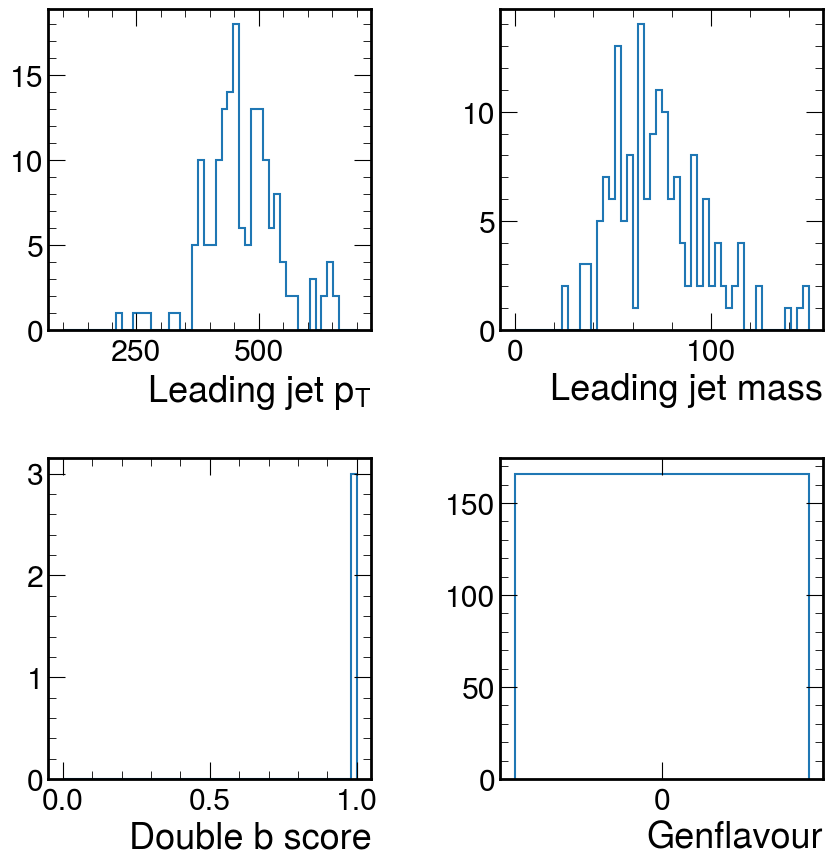

In [107]:
import mplhep
mplhep.style.use("CMS")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.4,hspace=0.4)

mplhep.histplot(out['templates'].project("pt"), ax=axs[0,0])
mplhep.histplot(out['templates'].project("mass"), ax=axs[0,1])
mplhep.histplot(out['templates'].project("ddb"), ax=axs[1,0])
mplhep.histplot(out['templates'].project("genflavour"), ax=axs[1,1])

plt.show()